# Remove Image Background with DeepLabV3 Image Segmentation

---

Credits: Original code by @ [eugenesiow/practical-ml](https://github.com/eugenesiow/practical-ml). Only slight modifications have been applied.

The used model is this:
https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

---

In [ ]:
!unzip "/content/Image-Cropped-Augmented.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Image-Cropped/train/images/p_085_jpg.rf.7e4a0c238cc31fc52195b6fa5aba67fd.jpg  
  inflating: Image-Cropped/train/images/p_085_jpg.rf.87c761200ee3899a50ed5375afabddf5.jpg  
  inflating: Image-Cropped/train/images/p_085_jpg.rf.b38de40f37161f56ae60dd202647dc12.jpg  
  inflating: Image-Cropped/train/images/p_087_jpg.rf.634580058eb276624272b4ded094995c.jpg  
  inflating: Image-Cropped/train/images/p_087_jpg.rf.995bbad5c73285fded301eaaa52eb5b3.jpg  
  inflating: Image-Cropped/train/images/p_087_jpg.rf.c8bc219521a9749c117c9a8c350afee4.jpg  
  inflating: Image-Cropped/train/images/p_088_jpg.rf.68777ffb1580318f6cc45b5c88adb6a2.jpg  
  inflating: Image-Cropped/train/images/p_088_jpg.rf.945d1c1379e6d5d62353e7a45e1f4041.jpg  
  inflating: Image-Cropped/train/images/p_088_jpg.rf.acf65ea296b6bd39b874b38b72e3c7a9.jpg  
  inflating: Image-Cropped/train/images/p_089_jpg.rf.4744109eccd6ecee5d964528d86163e8.jpg  
  inflating: Image-Cropped/tr

In [ ]:
# TODO: Upload your file and define the filename input_file
# Optional: Also upload or define the background file/url
input_file = '/content/Image-Cropped/train/images/a_003_jpg.rf.675f25f800ca063d468c39bc4ff6da15.jpg'
background_url = 'https://images.unsplash.com/photo-1475139441338-693e7dbe20b6?auto=format&fit=crop&w=640&q=427'

background_file = '/content/background.jpg'
foreground_file = '/content/foreground.png'
output_file = '/content/final.jpg'

In [ ]:
from urllib.request import urlretrieve
from PIL import Image
from matplotlib import pyplot as plt

# save the background
# urlretrieve(background_url, background_file)

# plt.imshow(Image.open(background_file))

In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from google.colab.patches import cv2_imshow

def load_model():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  r, g, b = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, 0).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)
  new_mask = np.stack([mask, mask, mask], axis=2)
  input_image = np.array(input_image)
  input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)
  input_image = np.where(new_mask, input_image, new_mask).astype(np.uint8)
  #cv2_imshow(input_image)
  #foreground = make_transparent_foreground(input_image ,bin_mask)

  return input_image, bin_mask

In [ ]:
directory = "/content/Image-Cropped/test/images"
import os
print(len(os.listdir(directory)))

260


In [ ]:
!mkdir /content/Image-Cropped-Aug-Seg/train
!mkdir /content/Image-Cropped-Aug-Seg/test
!mkdir /content/Image-Cropped-Aug-Seg/valid
!mkdir /content/Image-Cropped-Aug-Seg/train/images
!mkdir /content/Image-Cropped-Aug-Seg/test/images
!mkdir /content/Image-Cropped-Aug-Seg/valid/images

In [ ]:
import os
from google.colab.patches import cv2_imshow
deeplab_model = load_model()
directory = "/content/Image-Cropped/valid/images"
dst = "/content/Image-Cropped-Aug-Seg/valid/images"
for filename in os.listdir(directory):
    input_file = os.path.join(directory, filename)
    img, bin_mask = remove_background(deeplab_model, input_file)
    cv2.imwrite(os.path.join(dst, filename), img)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
!zip -r Image-Cropped-Aug-Seg.zip Image-Cropped-Aug-Seg

Streaming output truncated to the last 5000 lines.
  adding: Image-Cropped-Aug-Seg/train/images/c_100_jpg.rf.257ebbf5853468b27d057f40c45fe521.jpg (deflated 9%)
  adding: Image-Cropped-Aug-Seg/train/images/k_058_jpg.rf.629abc2150d1b9eff857fa6905d5dc8d.jpg (deflated 10%)
  adding: Image-Cropped-Aug-Seg/train/images/x_092_jpg.rf.db427f4ad28af6213098a05f1454e0d0.jpg (deflated 9%)
  adding: Image-Cropped-Aug-Seg/train/images/c_017_jpg.rf.133657a985d62ab396d8efd4aabf833a.jpg (deflated 10%)
  adding: Image-Cropped-Aug-Seg/train/images/g_016_jpg.rf.1fd120b75607f0f6e4e5dee8818e172a.jpg (deflated 12%)
  adding: Image-Cropped-Aug-Seg/train/images/x_028_jpg.rf.74985aa12575ecb70461c78d4caf13a4.jpg (deflated 7%)
  adding: Image-Cropped-Aug-Seg/train/images/r_058_jpg.rf.4f034fbcd2695070aa6a1f38cfa1deac.jpg (deflated 8%)
  adding: Image-Cropped-Aug-Seg/train/images/m_005_jpg.rf.2a1d719f71cb975f27505dac9998c893.jpg (deflated 9%)
  adding: Image-Cropped-Aug-Seg/train/images/w_030_jpg.rf.72e605f08a770457

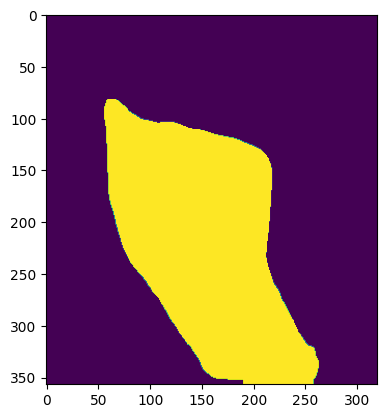

In [ ]:
plt.imshow(bin_mask)

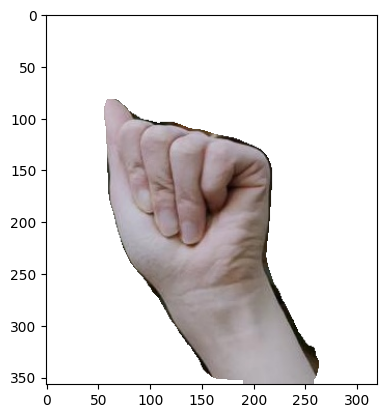

In [ ]:
plt.imshow(foreground)

In [ ]:
img_fg = Image.fromarray(foreground)
if foreground_file.endswith(('jpg', 'jpeg')):
  img_fg = img_fg.convert('RGB')

img_fg.save(foreground_file)

In [ ]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0]-final_foreground.size[0])/2 + 0.5
  y = (background.size[1]-final_foreground.size[1])/2 + 0.5
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  # put the foreground in the centre of the background
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)
  return final_image

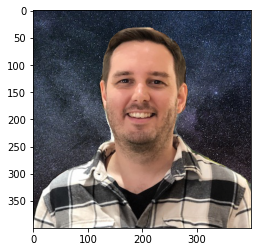

In [ ]:
final_image = custom_background(background_file, foreground)
plt.imshow(final_image)

In [ ]:
final_image.save(output_file)